In [73]:
from abc import ABC, abstractmethod
import numpy as np
import sklearn.datasets as skd
from numpy.random import PCG64
from torch import nn, Tensor
import torch as torch
from tqdm import notebook
import unittest
%reload_ext ipython_unittest

# Flow Matching
Let $q$ be a complex target distribution over $\mathbb{R}^d$. Let $p$ be a simple distribution over the same space that can be easily sampled (for example $p \sim \mathcal{N}(0, I)$)

### Goal
We want to construct a probability path $p_t$ with $t \in [0,1]$ s.t. $p_0 = p$ and $p_1 = q$. Every $p_t$ is a valid probability density function (PDF).

Given a sample $X_0 \sim p$, the goal is to estimate the corresponding $X_1 \sim q$ using an Ordinary Differential Equation (ODE).
Let $u : [0, 1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ be a *velocity* field $u$ and $\psi  : [0, 1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ its corresponding *flow*, given by the ODE:
$$
\frac{d}{dt}\psi_t(x) = u_t(\psi_t(x))
$$
where $\psi_t = \psi(t, x)$ and $\psi_0(x) = x$


In [74]:
def euler(x_t, h, direction):
    return x_t + h * direction


class InterpolationMethod(ABC):
    @classmethod
    @abstractmethod
    def apply(cls, t: Tensor, x_0: Tensor, x_1: Tensor):
        """Returns the random variable X_t."""
        pass


class OptimalTransport(InterpolationMethod):
    """Uses the L2-norm optimal transport."""

    def __init__(self):
        super().__init__()

    def apply(self, t, x_0, x_1):
        return (1 - t) * x_0 + t * x_1


class FlowMatching(nn.Module):
    """A simple MLP, representing a parametrized velocity field."""

    def __init__(self, input_dim=3, hidden_dim=256, output_dim=2, n_layers=4, *args, **kwargs):
        super().__init__(*args, **kwargs)

        layers = [nn.Linear(input_dim, hidden_dim), nn.GELU()]
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.GELU()])
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, t, x):
        tx_input = torch.cat((t, x), -1)
        return self.network(tx_input)


def sample_from_p(n):
    return torch.tensor(RNG.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)).float()


def sample_from_q(n):
    sample = torch.from_numpy(skd.make_moons(n_samples=n, noise=0.005)[0]).float()
    angle_rad = 45 * np.pi / 180  # Convert angle to radians
    c, s = np.cos(angle_rad), np.sin(angle_rad)

    rotation_matrix = torch.tensor([[2 * c, -s],
                                    [s, 2 *  c]], dtype=torch.float32)
    rotated_sample = sample @ rotation_matrix
    return rotated_sample + torch.tensor(SHIFT_TARGET_BY)

In [75]:
%%unittest_main
# Test for the optimal transport.


class TestOptimalTransport(unittest.TestCase):
    def test_simple(self):
        x_0 = Tensor((0, 0, 0, 0, 0))
        x_1 = Tensor((1, 1, 1, 1, 1))
        t = Tensor((0, 0.25, 0.5, 0.75, 1))
        usedMethod = OptimalTransport()
        actual = usedMethod.apply(t, x_0, x_1)
        self.assertTrue(torch.equal(actual, Tensor([0, 0.25, 0.5, 0.75, 1])))

    def test_2d(self):
        x_0 = Tensor([[0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0]])
        x_1 = Tensor([[1, 1, 1, 1, 1],
                      [2, 2, 2, 2, 2]])
        t = Tensor([0, 0.25, 0.5, 0.75, 1])
        usedMethod = OptimalTransport()
        actual = usedMethod.apply(t, x_0, x_1)
        expected = Tensor([[0.0, 0.25, 0.5, 0.75, 1.0],
                           [0.0, 0.5, 1.0, 1.5, 2.0]])
        self.assertTrue(torch.equal(actual, expected))

Success

..
----------------------------------------------------------------------
Ran 2 tests in 0.000s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [76]:
SHIFT_TARGET_BY = [4, 4]
SOLVER = euler

PATH_DESIGN = OptimalTransport()
RNG = np.random.Generator(PCG64(seed=44))
N_TEST_SAMPLES = 100


In [77]:
EPOCHS = 10000
BATCH_SIZE = 2000
LR = 1e-3

model = FlowMatching()  # Simple MLP.
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss = nn.MSELoss()

for epoch in notebook.tqdm(range(EPOCHS)):
    x_0 = sample_from_p(BATCH_SIZE)
    x_1 = sample_from_q(BATCH_SIZE)
    t = torch.rand(BATCH_SIZE, 1) # Sample t randomly from [0, 1].

    # Calculate X_t based on conditional optimal transport.
    x_t = OptimalTransport().apply(t, x_0, x_1)
    v_predicted = model(t, x_t)
    difference = x_1 - x_0

    optimizer.zero_grad()
    loss(v_predicted, difference).backward()
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [78]:
trajectories = []

INFERENCE_STEPS = 50
x_t = sample_from_p(N_TEST_SAMPLES)
delta_t = 1 / INFERENCE_STEPS

# Forward trajectory for an unseen noisy test sample.
with torch.no_grad():
    for current_step in range(INFERENCE_STEPS):
        t = delta_t * current_step
        t_tensor = torch.full((x_t.shape[0], 1), t)
        prediction = model(t_tensor.float(), x_t.float())
        x_t = euler(x_t, delta_t, prediction)
        trajectories.append(x_t)

## The following cells for creating visualizations have mostly been created using Generative AI.

In [79]:
fm_model = model

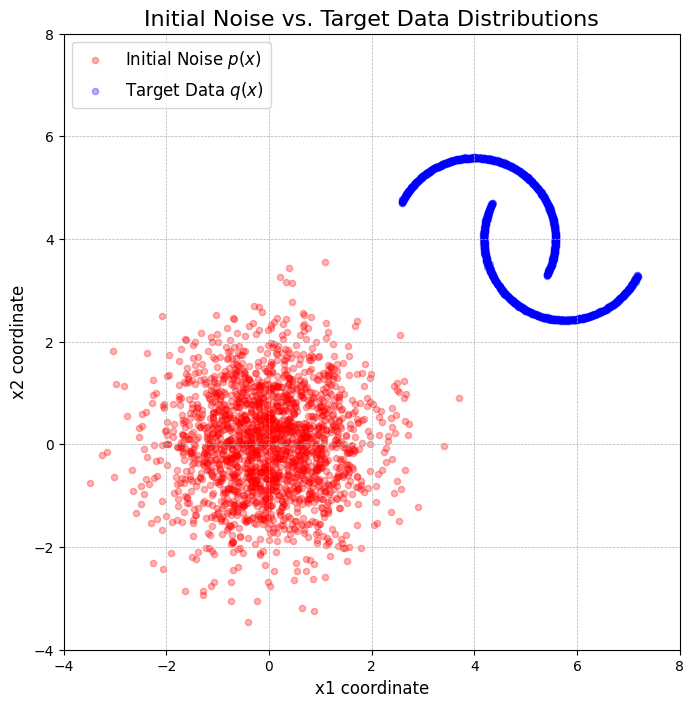

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Generate samples for visualization
N_SAMPLES = 2000
initial_noise_samples = sample_from_p(N_SAMPLES).numpy()
target_data_samples = sample_from_q(N_SAMPLES).numpy()

# --- MODIFIED: Switched to the object-oriented API for more control ---
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_title("Initial Noise vs. Target Data Distributions", fontsize=16)
ax.set_xlabel("x1 coordinate", fontsize=12)
ax.set_ylabel("x2 coordinate", fontsize=12)

# Plot the initial noise distribution
ax.scatter(initial_noise_samples[:, 0], initial_noise_samples[:, 1],
            color='red', alpha=0.3, s=20, label=r'Initial Noise $p(x)$')

# Plot the target data distribution
ax.scatter(target_data_samples[:, 0], target_data_samples[:, 1],
            color='blue', alpha=0.3, s=20, label=r'Target Data $q(x)$')

# Set consistent plot limits
ax.set_xlim([-4, 8])
ax.set_ylim([-4, 8])

# Explicitly set the ticks to ensure the full range is shown
ticks = np.arange(-4, 9, 2)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- THE FIX: Use ax.set_aspect() instead of plt.axis('equal') ---
# This enforces the aspect ratio without changing the data limits.
ax.set_aspect('equal', adjustable='box')

ax.legend(loc='upper left', fontsize=12)
plt.show()

In [81]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import display, Markdown

# --- 1. Animation & Simulation Setup ---
N_ANIMATION_SAMPLES = 500  # Number of particles to animate
FRAMES = 120               # Number of frames in the animation
FILENAME = 'flow_matching_scaled_field.mp4'

# Sample initial points from p(x) and target points from q(x)
x_0_samples = sample_from_p(N_ANIMATION_SAMPLES)
x_1_samples = sample_from_q(N_ANIMATION_SAMPLES)

# Define the time step (dt) used for both trajectory generation and arrow scaling
DT = 1.0 / FRAMES


# --- 2. Trajectory Generation Function (Unchanged) ---
@torch.no_grad()
def generate_flow_trajectory(model, initial_noise, num_frames):
    """
    Simulates the entire particle flow from t=0 to t=1 and returns the full trajectory.
    """
    x_t = initial_noise.clone()
    trajectory = torch.zeros((num_frames, initial_noise.shape[0], 2))
    trajectory[0] = x_t

    print("Generating trajectory for animation...")
    for i in range(num_frames - 1):
        t = torch.full((initial_noise.shape[0], 1), i * DT) # Use global DT
        velocity = model(t.float(), x_t.float())
        x_t = euler(x_t, DT, velocity) # Use global DT
        trajectory[i + 1] = x_t

    print("Trajectory generation complete.")
    return trajectory.numpy()


# --- 3. Animation Creation Function (with Scaled Vector Field) ---
def create_animation_with_scaled_field(trajectory, target_samples, filename):
    """
    Creates an animation showing the particle flow and the learned vector field
    with arrows scaled by dt for actual displacement.
    """
    # --- Set up the figure and a single axes object ---
    fig, ax = plt.subplots(figsize=(8, 8))

    # --- Plotting Area and Grid Setup for the Vector Field ---
    plot_min, plot_max = -4, 8
    GRID_DENSITY = 18
    x_grid = torch.linspace(plot_min, plot_max, GRID_DENSITY)
    y_grid = torch.linspace(plot_min, plot_max, GRID_DENSITY)
    X_grid, Y_grid = torch.meshgrid(x_grid, y_grid, indexing='xy')
    grid_points = torch.stack([X_grid.reshape(-1), Y_grid.reshape(-1)], dim=-1).float()

    # --- Configure main plot ---
    ax.set_xlim(plot_min, plot_max)
    ax.set_ylim(plot_min, plot_max)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel("x coordinate", fontsize=12)
    ax.set_ylabel("y coordinate", fontsize=12)

    # Plot static elements
    ax.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.15, s=15, color='blue', label='Target Distribution')
    scatter = ax.scatter([], [], alpha=0.7, s=15, color='red', label=r'$p_t(x)$ Samples')
    time_text = ax.set_title('', fontsize=14)

    # --- Initialize the Quiver (Vector Field) Plot ---
    # Calculate the scaled field at t=0 for initialization
    t0_tensor = torch.full((grid_points.shape[0], 1), 0.0)
    with torch.no_grad():
        v_field_0 = model(t0_tensor.float(), grid_points.float()) * DT # Scale by DT

    quiver = ax.quiver(grid_points[:, 0], grid_points[:, 1],
                       v_field_0[:, 0], v_field_0[:, 1],
                       color='green', alpha=0.2, # More transparent
                       scale_units='xy', scale=1, width=0.003, headwidth=5, headlength=5) # Scale=1 means actual length
    ax.legend(loc='upper left')

    # --- Animation update function ---
    def update(frame):
        # Update the positions of the moving particles
        scatter.set_offsets(trajectory[frame])

        # Calculate current time and update the title
        current_t = frame * DT # Use DT
        time_text.set_text(f'Flow Matching Transformation\nTime t = {current_t:.2f}')

        # Recalculate and update the vector field for the current time, scaled by DT
        current_t_tensor = torch.full((grid_points.shape[0], 1), current_t)
        with torch.no_grad():
            v_field_current = model(current_t_tensor.float(), grid_points.float()) * DT # Scale by DT
        quiver.set_UVC(v_field_current[:, 0], v_field_current[:, 1])

        # Return all artists that need to be redrawn
        return scatter, time_text, quiver

    # --- Generate and Save Animation ---
    print(f"Creating animation for {filename}... This may take a moment. ⏳")
    ani = animation.FuncAnimation(fig, update, frames=trajectory.shape[0], blit=True, interval=50)
    try:
        ani.save(filename, writer='ffmpeg', fps=30, dpi=120)
        print(f"Animation saved successfully as '{filename}' ✅")
    except Exception as e:
        print(f"Error saving animation: {e}\nPlease ensure ffmpeg is installed and accessible.")
    plt.close(fig)


# --- 4. Main Execution ---
# First, generate the full particle trajectory using the trained model
fm_trajectory = generate_flow_trajectory(model, x_0_samples, num_frames=FRAMES)

# Second, create the animation from the generated trajectory data
create_animation_with_scaled_field(fm_trajectory, x_1_samples, FILENAME)

# Display a link to the saved file for easy access
display(Markdown(f"### [Download Animation]({FILENAME})"))

Generating trajectory for animation...
Trajectory generation complete.
Creating animation for flow_matching_scaled_field.mp4... This may take a moment. ⏳
Animation saved successfully as 'flow_matching_scaled_field.mp4' ✅


### [Download Animation](flow_matching_scaled_field.mp4)

In [82]:
# This cell contains all the necessary components for the diffusion model.
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm

class DiffusionScheduler:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    def add_noise(self, x_start, t, noise):
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        return sqrt_alpha_t * x_start + sqrt_one_minus_alpha_t * noise

# This cell defines an improved DenoiseModel with a larger hidden dimension.

class DenoiseModel(nn.Module):
    # Increased hidden_dim from 128 to 256 for more capacity
    def __init__(self, input_dim=2, time_emb_dim=32, hidden_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(time_emb_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, hidden_dim))
        self.network = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.time_emb_dim = time_emb_dim

    def forward(self, x, t):
        half_dim = self.time_emb_dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim) * -emb)
        emb = t[:, None] * emb[None, :]
        time_emb = self.time_mlp(torch.cat((emb.sin(), emb.cos()), dim=1))
        xt_input = torch.cat([x, time_emb], dim=-1)
        return self.network(xt_input)

# The training function remains the same but will now use the updated model class.
def train_diffusion_model(epochs=10000, batch_size=2048):
    print("--- Training Diffusion Model ---")
    model = DenoiseModel() # Instantiates the new, larger model
    scheduler = DiffusionScheduler()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in tqdm(range(epochs), desc="Training DM"):
        x_start = sample_from_q(batch_size)
        t = torch.randint(0, scheduler.num_timesteps, (batch_size,))
        noise = torch.randn_like(x_start)
        x_noisy = scheduler.add_noise(x_start, t, noise)
        noise_pred = model(x_noisy, t.float())
        loss = loss_fn(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Diffusion training complete!\n")
    return model, scheduler

In [ ]:
# Re-train the improved diffusion model with more epochs for better convergence.
DIFFUSION_EPOCHS = 30000

# This assumes 'fm_model' is already trained and available.
diff_model, diff_scheduler = train_diffusion_model(epochs=DIFFUSION_EPOCHS)

--- Training Diffusion Model ---


Training DM:   0%|          | 0/30000 [00:00<?, ?it/s]

In [101]:
# This function generates the high-quality "noise-to-data" (denoising) trajectory for the diffusion model.

@torch.no_grad()
def generate_diffusion_generative_trajectory(model, scheduler, initial_noise, num_frames):
    """
    Generates a high-quality trajectory by running the FULL denoising process
    and then selecting a subset of frames for the animation.
    """
    x_t = initial_noise.clone()

    # This list will store the entire 1000-step history
    full_trajectory = [x_t.clone()]

    # Run the complete denoising loop from T-1 down to 0
    for t_step in range(scheduler.num_timesteps - 1, -1, -1):
        t = torch.full((initial_noise.shape[0],), t_step, dtype=torch.long)
        pred_noise = model(x_t, t.float())

        alpha_t = scheduler.alphas[t].view(-1, 1)
        alpha_t_cumprod = scheduler.alphas_cumprod[t].view(-1, 1)
        beta_t = scheduler.betas[t].view(-1, 1)

        mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_cumprod)) * pred_noise)

        if t_step > 0:
            x_t = mean + torch.sqrt(beta_t) * torch.randn_like(x_t)
        else:
            x_t = mean

        full_trajectory.append(x_t.clone())

    # Now, select 'num_frames' evenly spaced samples from the full history
    indices_to_sample = np.linspace(0, len(full_trajectory) - 1, num_frames, dtype=int)

    # Create the final animation trajectory
    animation_trajectory = torch.stack([full_trajectory[i] for i in indices_to_sample])

    return animation_trajectory

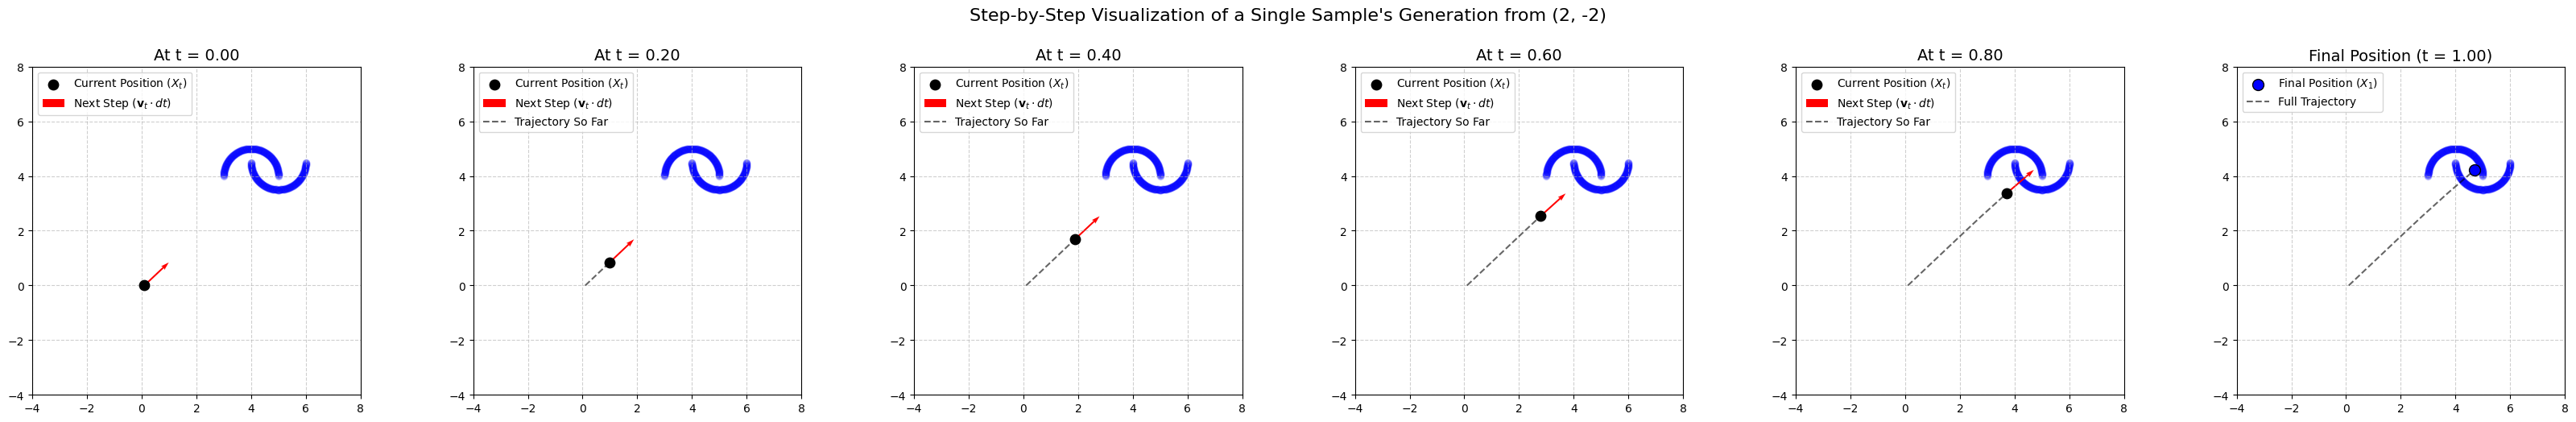

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- 1. Setup the Simulation ---
N_STEPS = 5
DT = 1.0 / N_STEPS

# Set a fixed starting point
x_0_single = torch.tensor([[2.123, -1.9]])

# --- 2. Run the 5-Step Generation Process ---
x_current = x_0_single.clone()
x_history = [x_current.numpy()]
v_history = []
displacement_history = []

for i in range(N_STEPS):
    t_tensor = torch.tensor([[i * DT]])
    with torch.no_grad():
        v_current = fm_model(t_tensor, x_current)

    displacement = v_current * DT
    x_next = x_current + displacement

    v_history.append(v_current.numpy())
    displacement_history.append(displacement.numpy())
    x_history.append(x_next.numpy())

    x_current = x_next

# --- 3. Create the 6 Subplots ---
fig, axes = plt.subplots(1, 6, figsize=(33, 5))

q_samples = sample_from_q(500).numpy()
full_path = np.concatenate(x_history)

# Plot the 5 intermediate steps
for i in range(N_STEPS):
    ax = axes[i]
    current_time = i * DT

    ax.set_title(f"At t = {current_time:.2f}", fontsize=14)
    ax.set_xlim([-4, 8])
    ax.set_ylim([-4, 8])
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.scatter(q_samples[:, 0], q_samples[:, 1], alpha=0.1, color='blue')

    x_i = x_history[i].flatten()
    disp_i = displacement_history[i].flatten()

    # Plotting order is set to control legend order
    ax.scatter(x_i[0], x_i[1], c='black', s=80, zorder=10, label=r'Current Position ($X_t$)')

    # --- MODIFIED: Label changed to "Next Step" ---
    ax.quiver(x_i[0], x_i[1], disp_i[0], disp_i[1], color='red', scale_units='xy', scale=1, width=0.005, label=r'Next Step ($\mathbf{v}_t \cdot dt$)')

    path_so_far = full_path[:i+1]
    traj_label = 'Trajectory So Far' if i > 0 else None
    ax.plot(path_so_far[:, 0], path_so_far[:, 1], 'k--', alpha=0.6, linewidth=1.5, label=traj_label)

    ax.legend(loc='upper left')

# --- 4. Plot the Final State at t=1.0 ---
ax_final = axes[5]
ax_final.set_title("Final Position (t = 1.00)", fontsize=14)
ax_final.set_xlim([-4, 8])
ax_final.set_ylim([-4, 8])
ax_final.set_aspect('equal', adjustable='box')
ax_final.grid(True, linestyle='--', alpha=0.6)

ax_final.scatter(q_samples[:, 0], q_samples[:, 1], alpha=0.1, color='blue')

ax_final.scatter(x_history[-1].flatten()[0], x_history[-1].flatten()[1], c='blue', s=100, zorder=10, edgecolors='black', label=r'Final Position ($X_1$)')
ax_final.plot(full_path[:, 0], full_path[:, 1], 'k--', alpha=0.6, linewidth=1.5, label='Full Trajectory')
ax_final.legend(loc='upper left')

# Add a main title to the figure
fig.suptitle("Step-by-Step Visualization of a Single Sample's Generation from (2, -2)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()